In [22]:
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
import tensorflow as tf

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)
np.random.seed(1)

In [23]:
# 读取数据

train_dataset = h5py.File('train_signs.h5', "r")# 训练集 
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 64*64*1080
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 标签为0-5

test_dataset = h5py.File('test_signs.h5', "r") # 测试集
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 
 
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

y = 2


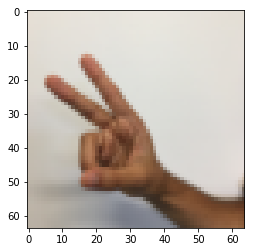

In [24]:
# 可视化

plt.imshow(train_set_x_orig[6])
print ("y = " + str(np.squeeze(train_set_y_orig[:, 6])))

In [25]:
# 数据预处理

X_train = train_set_x_orig/255.
X_test = test_set_x_orig/255.
Y_train = np.eye(6)[train_set_y_orig.reshape(-1)]
Y_test = np.eye(6)[test_set_y_orig.reshape(-1)]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [40]:
# 小批量随机

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [26]:
# 初始化

def create_placeholders(n_H0, n_W0, n_C0, n_y): # 创建占位符
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

def initialize_parameters(): # 卷积核初始化
    tf.set_random_seed(1)
    W1 = tf.get_variable('W1', [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2', [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {'W1': W1, 'W2': W2}
    
    return parameters

In [32]:
# 正向传播
# CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):

    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding = "SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding = "SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides=[1,4,4,1], padding = "SAME")
    
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)

    return Z3

def compute_cost(Z3, Y): # 成本
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    
    return cost


In [41]:
# 整个模型

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 32, print_cost = True):
    
    tf.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0;
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print("%i epoch后的损失：%f" %(epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
   
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("训练集识别准确度：", train_accuracy)
        print("测试集识别准确度:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

0 epoch后的损失：1.851765
5 epoch后的损失：1.245817
10 epoch后的损失：0.949923
15 epoch后的损失：0.863278
20 epoch后的损失：0.801096
25 epoch后的损失：0.741476
30 epoch后的损失：0.715074
35 epoch后的损失：0.691964
40 epoch后的损失：0.646158
45 epoch后的损失：0.629933
50 epoch后的损失：0.650554
55 epoch后的损失：0.584943
60 epoch后的损失：0.608915
65 epoch后的损失：0.532475
70 epoch后的损失：0.524319
75 epoch后的损失：0.550554
80 epoch后的损失：0.530132
85 epoch后的损失：0.608801
90 epoch后的损失：0.539770
95 epoch后的损失：0.495463


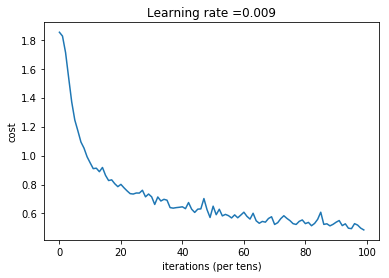

Tensor("Mean_1:0", shape=(), dtype=float32)
训练集识别准确度： 0.8074074
测试集识别准确度: 0.68333334


In [42]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)